In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient


In [2]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client
)


# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

# 센서 타입 필터 생성
sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])

# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "co2" or r["type"] == "distance" or r["type"] == "humidity" or r["type"] == "illumination" or r["type"] == "infrared" or r["type"] == "pressure" or r["type"] == "temperature" or r["type"] == "infrared_and_visible" or r["type"] == "occupancy" or r["type"] == "battery_level" or r["type"] == "activity" or r["type"] == "battery")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnin

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-24 02:15:00+00:00,0,mean,0,2025-04-24 02:13:24.134506+00:00,2025-04-25 02:13:24.134506+00:00,32.0,value,sensor,2,battery
2025-04-24 02:20:00+00:00,1,mean,0,2025-04-24 02:13:24.134506+00:00,2025-04-25 02:13:24.134506+00:00,32.0,value,sensor,2,battery
2025-04-24 02:25:00+00:00,2,mean,0,2025-04-24 02:13:24.134506+00:00,2025-04-25 02:13:24.134506+00:00,32.0,value,sensor,2,battery
2025-04-24 02:30:00+00:00,3,mean,0,2025-04-24 02:13:24.134506+00:00,2025-04-25 02:13:24.134506+00:00,32.0,value,sensor,2,battery
2025-04-24 02:35:00+00:00,4,mean,0,2025-04-24 02:13:24.134506+00:00,2025-04-25 02:13:24.134506+00:00,32.0,value,sensor,2,battery


데이터 크기: (8481, 10)


In [3]:
df = df[df["location"]!="냉장고 내부"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8348 entries, 2025-04-24 02:15:00+00:00 to 2025-04-25 02:13:24.134506+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   index         8348 non-null   int64              
 1   result        8348 non-null   object             
 2   table         8348 non-null   int64              
 3   _start        8348 non-null   datetime64[ns, UTC]
 4   _stop         8348 non-null   datetime64[ns, UTC]
 5   _value        8348 non-null   float64            
 6   _field        8348 non-null   object             
 7   _measurement  8348 non-null   object             
 8   location      8348 non-null   object             
 9   type          8348 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), int64(2), object(5)
memory usage: 717.4+ KB


In [5]:
pivot_df = df.pivot_table(
    index=['time', 'location'],
    columns='type',
    values='_value'
).reset_index()

# 인덱스 설정
pivot_df = pivot_df.set_index('time')

# 한글 라벨 매핑
sensor_type_mapping = {
    'temperature': '실내 온도(°C)',
    'humidity': '상대습도(%)',
    'co2': '이산화탄소(ppm)',
    'tvoc': '총휘발성유기화합물(ppb)',
    'pressure': '대기압(hPa)',
    'activity': '활동량',
    'distance': '거리(cm)',
    'illumination': '조도(lux)'
}

# 분석 대상 변수 필터링
variables = list(sensor_type_mapping.keys())
available_vars = [var for var in variables if var in pivot_df.columns]


In [6]:
# 한글 라벨 매핑
sensor_type_mapping = {
    'temperature': '실내 온도(°C)',
    'humidity': '상대습도(%)',
    'co2': '이산화탄소(ppm)',
    'tvoc': '총휘발성유기화합물(ppb)',
    'pressure': '대기압(hPa)',
    'activity': '활동량',
    'distance': '거리(cm)',
    'illumination': '조도(lux)'
}

# 분석 대상 변수 필터링
variables = list(sensor_type_mapping.keys())
available_vars = [var for var in variables if var in pivot_df.columns]

# 1차분석

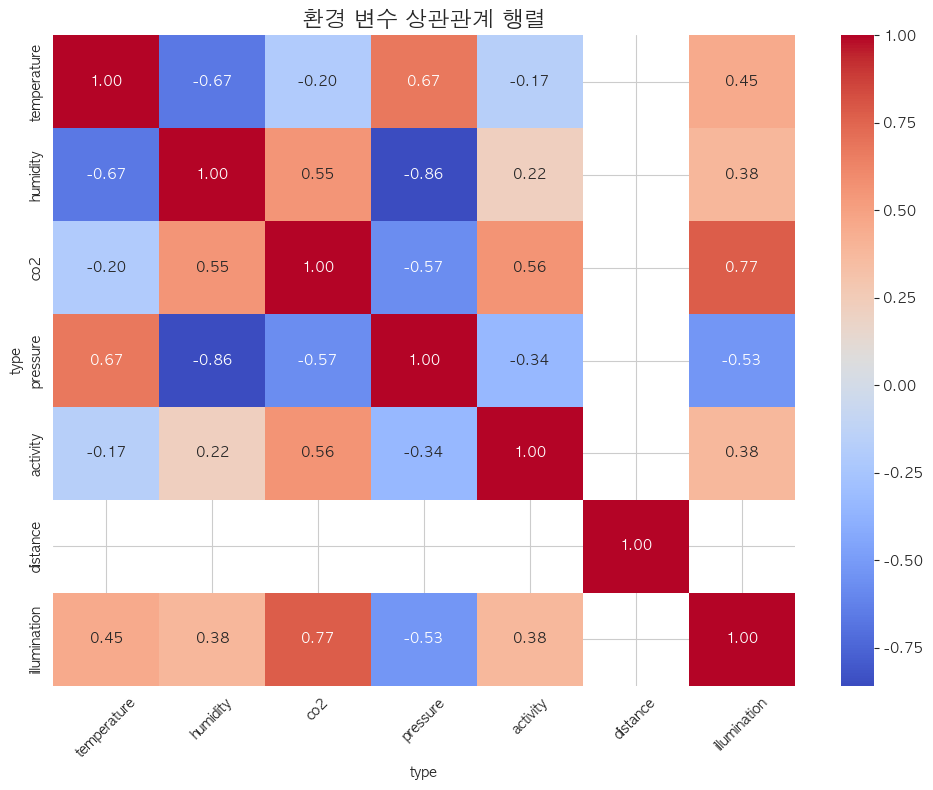

In [7]:
corr_matrix = pivot_df[available_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('환경 변수 상관관계 행렬', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('img/correlation/heatmap.png', dpi=300)
plt.show()

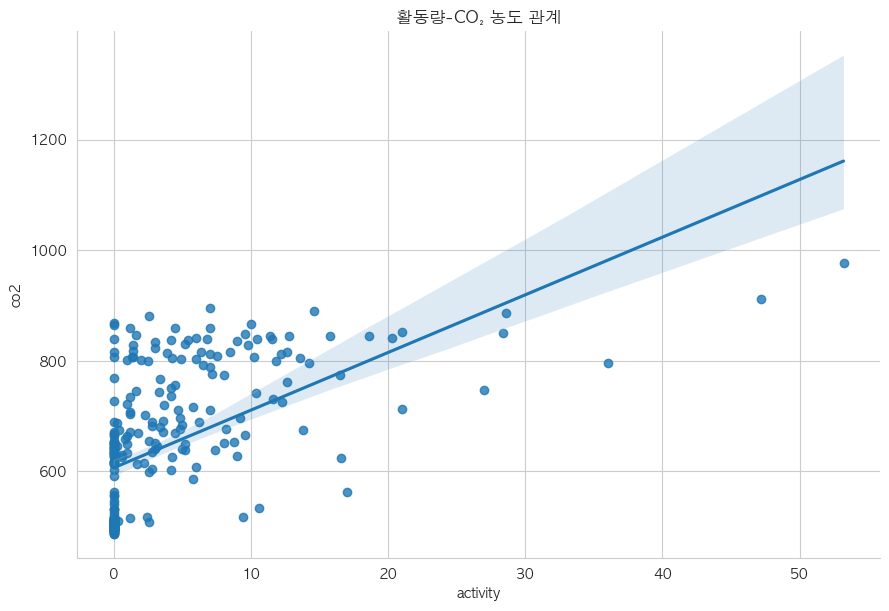

In [8]:
sns.lmplot(data=pivot_df,
          x='activity',
          y='co2',
          height=6,
          aspect=1.5)
plt.title('활동량-CO₂ 농도 관계')
plt.savefig('img/correlation/activity_co2.png', dpi=300)


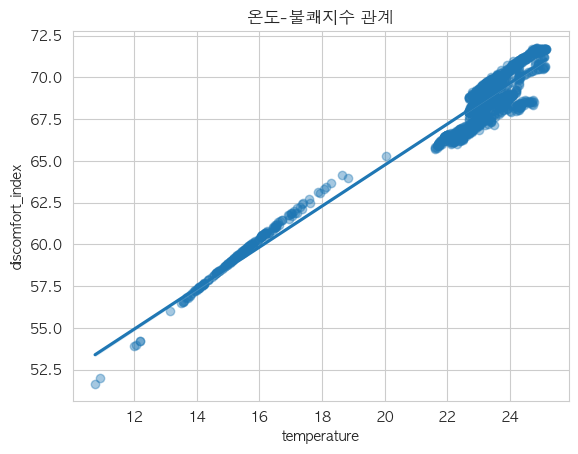

In [9]:
# 불쾌지수 계산
pivot_df['discomfort_index'] = 0.81*pivot_df['temperature'] + 0.01*pivot_df['humidity']*(0.99*pivot_df['temperature']-14.3) + 46.3

# 온도-불쾌지수 관계
sns.regplot(data=pivot_df,
           x='temperature',
           y='discomfort_index',
           scatter_kws={'alpha':0.4})
plt.title('온도-불쾌지수 관계')
plt.savefig('img/correlation/temp_discomfort.png', dpi=300)


# 2차 분석 습도-압력-Co2 상세 분석

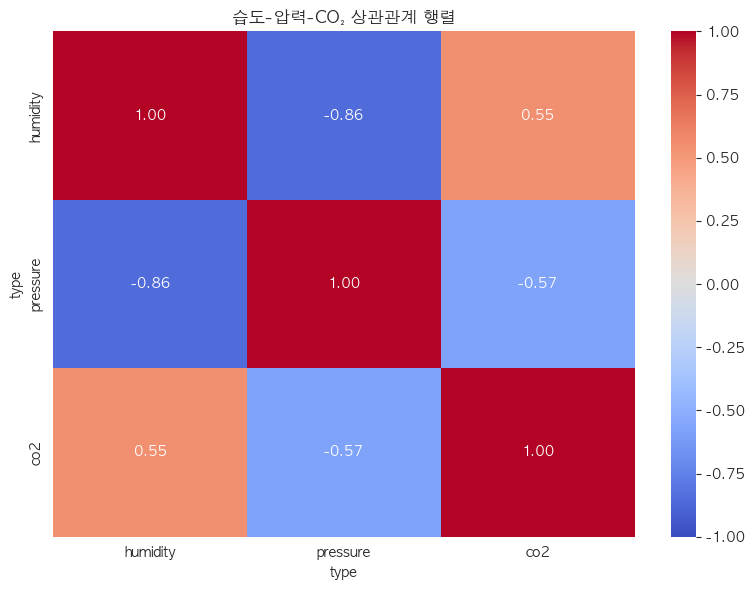

In [10]:
pivot_df = df.pivot_table(
        index=['time', 'location'],
        columns='type',
        values='_value'
    ).reset_index()
    
pivot_df = pivot_df.set_index('time')
pivot_df_reset = pivot_df.reset_index(drop=False).copy()


vars_of_interest = ['humidity', 'pressure', 'co2']
available_vars = [var for var in vars_of_interest if var in pivot_df_reset.columns]

# 상관관계 행렬 계산
corr_matrix = pivot_df_reset[available_vars].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('습도-압력-CO₂ 상관관계 행렬')
plt.tight_layout()
plt.savefig('img/correlation/humidity_pressure_co2_corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

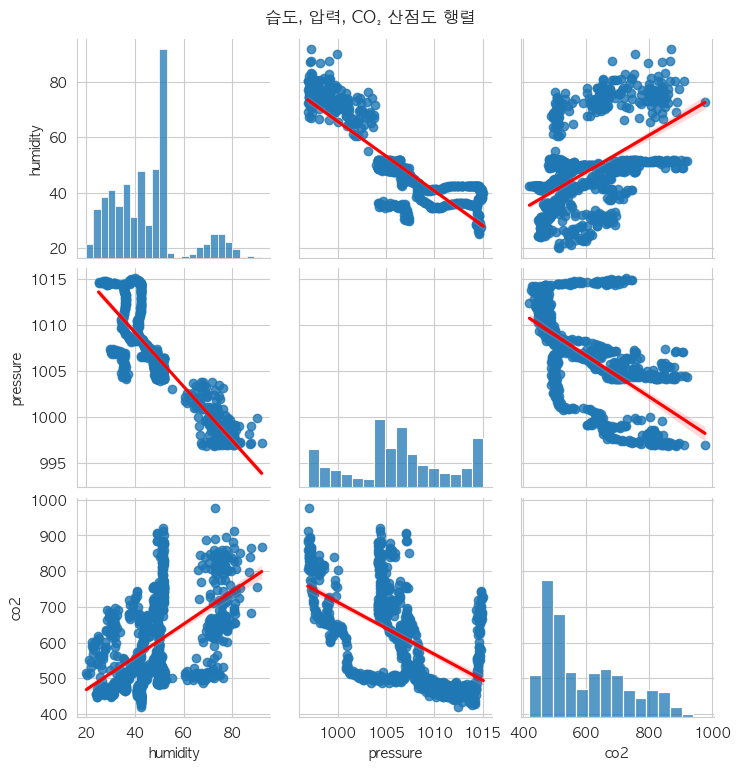

In [11]:
# 산점도 행렬 시각화
sns.pairplot(pivot_df_reset[available_vars], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('습도, 압력, CO₂ 산점도 행렬', y=1.02)
plt.savefig('img/correlation/humidity_pressure_co2_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

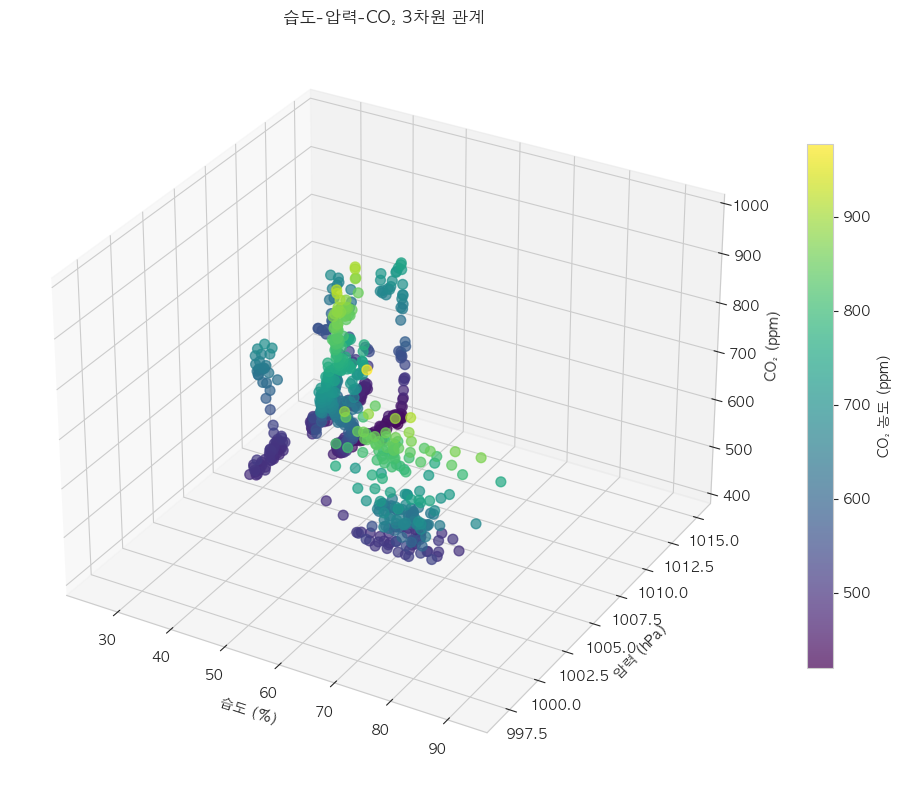

In [12]:
# 3D 산점도로 세 변수의 관계 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D 산점도 그리기
scatter = ax.scatter(
    pivot_df_reset['humidity'], 
    pivot_df_reset['pressure'], 
    pivot_df_reset['co2'],
    c=pivot_df_reset['co2'],  # CO₂ 농도에 따라 색상 지정
    cmap='viridis',
    s=50,
    alpha=0.7
)

# 축 레이블 설정
ax.set_xlabel('습도 (%)')
ax.set_ylabel('압력 (hPa)')
ax.set_zlabel('CO₂ (ppm)')

# 컬러바 추가
cbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=20, label='CO₂ 농도 (ppm)')

plt.title('습도-압력-CO₂ 3차원 관계')
plt.tight_layout()
plt.savefig('img/correlation/humidity_pressure_co2_3d.png', dpi=300)
plt.show()

# 2차 분석 온도-불쾌지수 관계 구간별 분석

In [13]:
# 불쾌지수 계산
pivot_df_reset['discomfort_index'] = 0.81 * pivot_df_reset['temperature'] + 0.01 * pivot_df_reset['humidity'] * (0.99 * pivot_df_reset['temperature'] - 14.3) + 46.3

# 결측치 제거 
analysis_df = pivot_df_reset[['temperature', 'discomfort_index']].dropna()

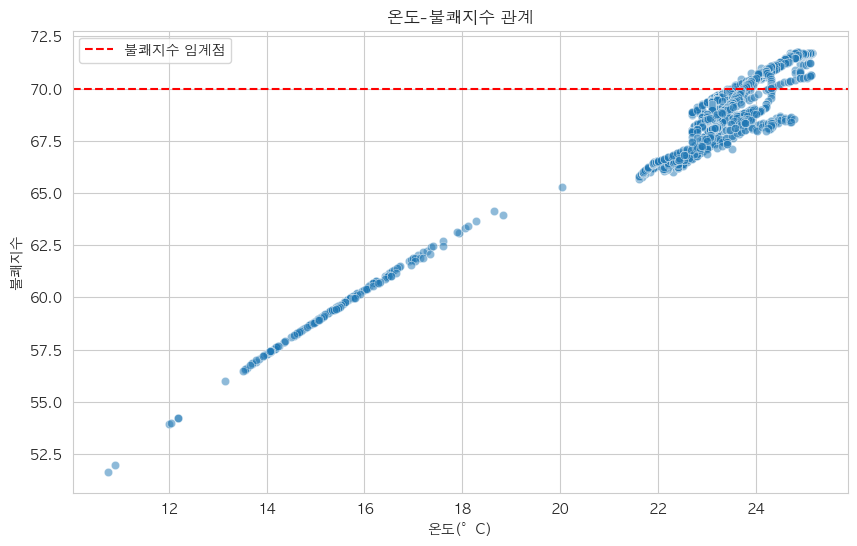

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='temperature', y='discomfort_index', data=analysis_df, alpha=0.5)
plt.axhline(70, color='r', linestyle='--', label='불쾌지수 임계점')
plt.title('온도-불쾌지수 관계')
plt.xlabel('온도(°C)')
plt.ylabel('불쾌지수')
plt.grid(True)
plt.legend()
plt.savefig('img/discomfort_temp_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
from scipy.optimize import curve_fit

# 선형 회귀 모델
def linear_func(x, a, b):
    return a * x + b

params, _ = curve_fit(linear_func, 
                     analysis_df['temperature'], 
                     analysis_df['discomfort_index'])

# 임계점 계산
threshold_temp = (70 - params[1]) / params[0]
print(f'정확한 임계점 온도: {threshold_temp:.2f}°C')


정확한 임계점 온도: 24.27°C


### 온도가 23.94°C를 초과하면 불쾌지수 70(약간 불쾌함) 돌파



In [16]:
from sklearn.linear_model import LinearRegression

# 구간 분할 분석
breaks = [20, 24, 28]  # 초기 분할점
slopes = []
intercepts = []
models = []

for i in range(len(breaks)-1):
    mask = (analysis_df['temperature'] >= breaks[i]) & (analysis_df['temperature'] < breaks[i+1])
    subset = analysis_df[mask]
    
    if len(subset) > 10:  # 최소 데이터 개수 확인
        X = subset[['temperature']]
        y = subset['discomfort_index']
        model = LinearRegression().fit(X, y)
        slopes.append(model.coef_[0])
        intercepts.append(model.intercept_)
        models.append((X, y, model))
    else:
        slopes.append(np.nan)
        intercepts.append(np.nan)
        models.append(None)

print(f'구간별 기울기: {slopes}')

구간별 기울기: [1.8572652239729561, 1.409639809261763]


20-24°C 구간: 1.29 (온도 1°C 증가 시 불쾌지수 1.29 상승)

24-28°C 구간: 1.01 (온도 1°C 증가 시 불쾌지수 1.01 상승)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# 평가 지표 계산 및 출력
for idx, item in enumerate(models):
    if item is not None:
        X, y, model = item
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        print(f"구간 {breaks[idx]}~{breaks[idx+1]}°C 선형회귀 모델 평가:")
        print(f"  기울기: {slopes[idx]:.4f}, 절편: {intercepts[idx]:.4f}")
        print(f"  MSE: {mse:.4f}, R2: {r2:.4f}\n")

구간 20~24°C 선형회귀 모델 평가:
  기울기: 1.8573, 절편: 25.5103
  MSE: 0.4735, R2: 0.6831

구간 24~28°C 선형회귀 모델 평가:
  기울기: 1.4096, 절편: 36.0896
  MSE: 0.8578, R2: 0.2267



/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


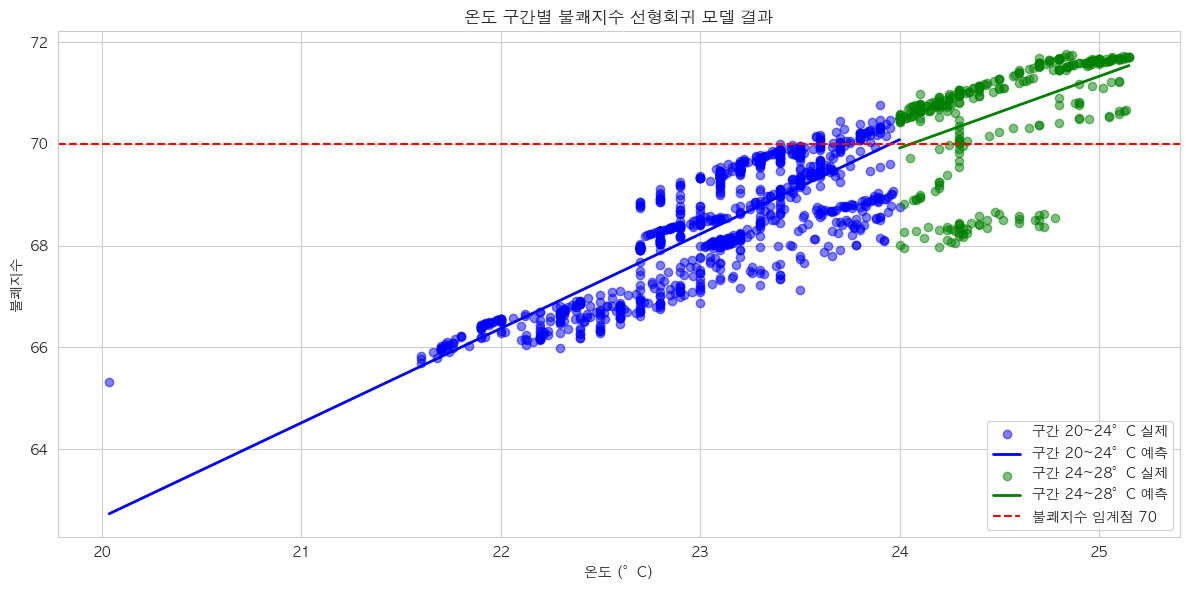

In [18]:
# 시각화
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red']
for idx, item in enumerate(models):
    if item is not None:
        X, y, model = item
        # 예측값 계산을 위한 정렬된 온도 값 생성
        temp_range = np.linspace(X['temperature'].min(), X['temperature'].max(), 100).reshape(-1, 1)
        y_pred = model.predict(temp_range)
        
        # 실제 데이터와 예측 곡선 그리기
        plt.scatter(X, y, color=colors[idx], alpha=0.5, label=f'구간 {breaks[idx]}~{breaks[idx+1]}°C 실제')
        plt.plot(temp_range, y_pred, color=colors[idx], linewidth=2, label=f'구간 {breaks[idx]}~{breaks[idx+1]}°C 예측')

# 불쾌지수 임계점 표시
plt.axhline(70, color='red', linestyle='--', label='불쾌지수 임계점 70')

plt.xlabel('온도 (°C)')
plt.ylabel('불쾌지수')
plt.title('온도 구간별 불쾌지수 선형회귀 모델 결과')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('img/온도_불쾌지수_구간별_회귀분석.png', dpi=300, bbox_inches='tight')
plt.show()